The following is a simple script that performs an astrophysical neutrino source class search using three years worth of publicly available IceCube muon track data and the 4LAC catalog from the Fermi satellite, a catalog of gamma-ray active galactic nuclei in the universe detected by the satellite. 

First, we load common libraries and `IceCubeAnalysis`, a custom library with two classes, the first (`SourceSearch`) that handle the creation of the neutrino source likelihood function given a source location to test and the second (`SourceClassSearch`) that handles the loading of 4LAC sources. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IceCubeAnalysis

Now that we know all the points on the sky, we create a new `SourceSearch` instance and load the pre-processed muon track data and background PDF.

In [3]:
sourcesearch_ = IceCubeAnalysis.SourceSearch("./processed_data/output_icecube_data.npz")
sourcesearch_.load_background("./processed_data/output_icecube_background_count.npz")

We need to define some parameters of the analysis, including the time of the analysis (`T`), energy bands of interest for plotting (`E1` and `E2`), the power spetrum of the neutrino flux (`alpha`), how to weight each source (`weights_type`), and the source class names of interest (`source_class_names`). 

In [4]:
T = (3.0 * 365.25 * 24.0 * 3600.0)
E1 = 100.0
E2 = 30.0
alpha = 2.0
weights_type = 'flat'
source_class_names = ['FSRQ', 'fsrq']

Next we load up the source class information, defined in `IceCubeAnalysis`, `SourceClassSearch`, using the 4LAC catalog pre-processed in `./processed_data/4LAC_catelogy.npz`. 

In [5]:
Aeff_filename = "processed_data/output_icecube_AffIntegrated_%s.npz" % alpha
class_search = IceCubeAnalysis.SourceClassSearch(T, E1, E2, alpha, sourcesearch_, Aeff_filename)
    
class_search.load_4lac("./processed_data/4LAC_catelogy.npz", source_class_names, weights_type)
    
print("Number of Sources:\t %i" % class_search.N)
print("Number of Events:\t %i" % sourcesearch_.N)

Number of Sources:	 658
Number of Events:	 1134450


Since it is computationally intensive to run the source search, I parallelize the computation. For overhead purposes, it is more efficient to run the scan over flux for each individual source per job and then combine them in post-processing. The `SourceClassSearch` instance performs the sweep on each individual source in the class using the function `source_loop` which accepts the integer of the source of interest. 

In [8]:
import time
from multiprocessing import Pool
n_cpu = 4

start_time = time.time()                        
pool = Pool(n_cpu)
parallel_results = pool.map(class_search.source_loop, np.arange(class_search.N))
pool.close()
end_time = time.time()
print("Using parallel, time passed was: \t %f" % (end_time - start_time))

Using parallel, time passed was: 	 8.189436


With the big computing done, the result is saved into `parallel_results`. The post processing to combine each source into one likelihood vs. flux measurement is below. 

In [9]:
parallel_results = [list(t) for t in zip(*parallel_results)]

sweep_ts_each_source = np.stack(parallel_results[1], axis=1)
sweep_ts = np.sum(parallel_results[1], axis=0)
sweep_flux = np.sum(parallel_results[0], axis=0)

sweep_flux *= 1000.0 # convert TeV to GeV

And now a plot of the results. 

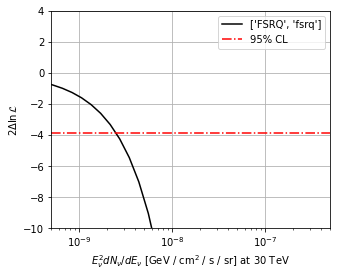

In [10]:
plt.figure(figsize=(5, 4))
plt.semilogx(np.array(sweep_flux)[sweep_ts < 1e3],
             sweep_ts[sweep_ts < 1e3],
             linestyle='-',
             color='black',
             label=source_class_names)

plt.axhline(-3.85,
            color="red",
            linestyle="-.",
            label="95% CL")
            
plt.xlabel(r"$E^2_\nu dN_\nu/dE_\nu$ [GeV / cm$^2$ / s / sr] at 30 TeV")
plt.ylabel("$2 \Delta \ln \mathcal{L}$")
plt.xlim(5e-10, 5e-7)
plt.ylim(-10.0, 4.0)
plt.grid()
plt.legend()